<a href="https://colab.research.google.com/github/khadija267/Load-Time-Series-Forcasting/blob/main/lsc_load_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Job Description
Create a model to forecast 15-min time-series electrical load data for a month.
We have 2 years of historical data to train the model, from 2021-present.
We need to create forecast for the next month.
The model also needs to take in temperature data for the location. We have the temperature data already.
We provide:
15 minute historical Time-series data for each of 3 sites
15 minute actual temperature data for the 3 sites



You provide:
15 minute load forecast for the next month


We provide:
15 minute historical Time-series data for each of 3 sites
15 minute actual temperature data for the 3 sites



You provide:
15 minute load forecast for the next month



Example. We have data for October 2021-March 2023. You provide a forecast for the month of April. (About 2976 data points, 15-minute)



There are 3 sites that we need to test this on now. Then we want the code to be able to run this in the future by our team.



We plan to use SARIMA, LSTM, etc. We specifically need to forecast one month, and would choose the method that produces the best results (on a different test month.)

In [3]:
#import libraries
from helper import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pylab
import missingno as msno
import seaborn as sns
import datetime
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
import statsmodels.graphics.tsaplots as sgt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### 1. Data Investigation

In [4]:
lsc_load=pd.read_csv('lsc.csv')
lsc_temp = pd.read_csv('lsc_temp.csv')




### 1.1 Data Investigate

In [5]:
lsc_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40895 entries, 0 to 40894
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Datetime MST  40895 non-null  object 
 1   Load          40895 non-null  float64
dtypes: float64(1), object(1)
memory usage: 639.1+ KB


In [6]:
lsc_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13847 entries, 0 to 13846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    13847 non-null  object 
 1   temp    13847 non-null  float64
dtypes: float64(1), object(1)
memory usage: 216.5+ KB


In [7]:
# check for the head
lsc_load.head()


,Datetime MST,Load
0,3/1/2022 0:15,85.38
1,3/1/2022 0:30,82.81
2,3/1/2022 0:45,81.88
3,3/1/2022 1:00,76.50
4,3/1/2022 1:15,76.75


Load data is represeted in 15 minutes

In [8]:

lsc_temp.head()


,time,temp
0,2021-10-01 01:00:00,26.1
1,2021-10-01 02:00:00,25.0
2,2021-10-01 03:00:00,24.4
3,2021-10-01 04:00:00,23.9
4,2021-10-01 05:00:00,23.9


Temperature data is represeted in hours

Check for duplicates


In [9]:
lsc_load.duplicated().any()

False

In [10]:
lsc_temp.duplicated().any()

False

> No duplicated entries in the data

Check for outliers


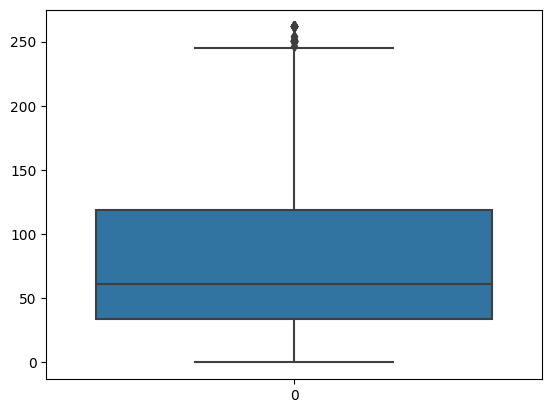

In [11]:
sns.boxplot(lsc_load.Load);

> There are some oulier points

Check for data discription


In [12]:
lsc_load.describe()

,Load
count,40895.000000
mean,80.324809
std,52.683940
min,0.000000
25%,34.250000
50%,61.130000
75%,118.855000
max,261.810000


In [13]:
lsc_temp.describe()

,temp
count,13847.000000
mean,20.163097
std,8.605824
min,-9.400000
25%,13.900000
50%,21.700000
75%,26.100000
max,41.100000


Ploting a QQ plot: <br>
To determine whether the data is distributed into a certain way.
How data can fit a normal distrubution

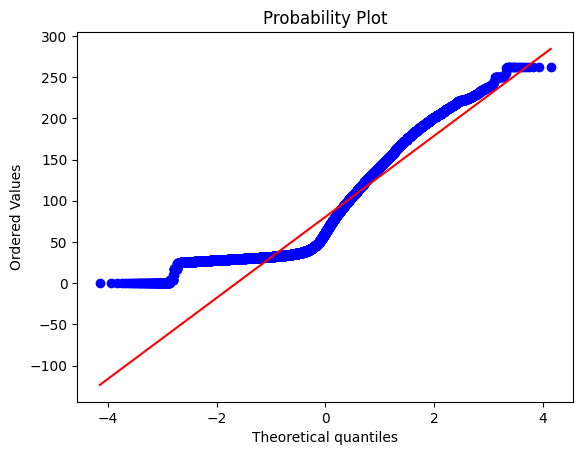

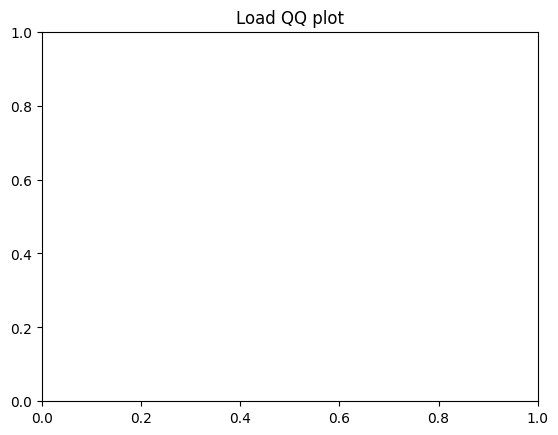

In [14]:
## Quantile Quarter plot (QQ plot)
scipy.stats.probplot(lsc_load.Load,plot=pylab)
pylab.show()


> According to the QQ plot above
- There are more values around [0-50]; Data is not normally distributed.

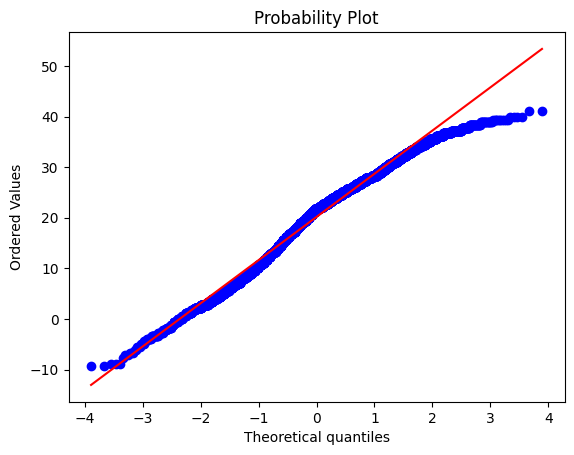

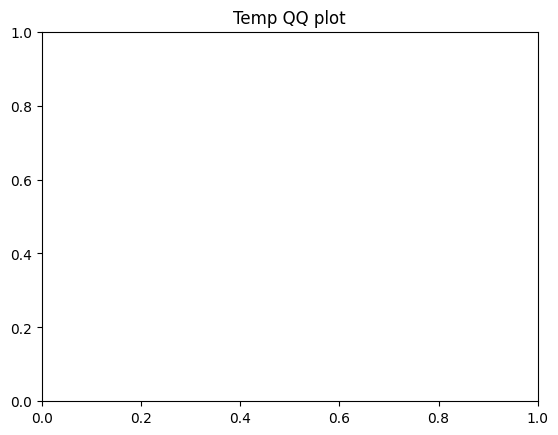

In [15]:
scipy.stats.probplot(lsc_temp.temp,plot=pylab)
pylab.show()


- There are more values around 40 Data is not normally distributed.

Create Date time index

In [16]:
# convert the Datetime MST to datetime data type in utc timezone
lsc_load['Datetime MST']=pd.to_datetime(lsc_load['Datetime MST'],utc=True)
lsc_temp['time']=pd.to_datetime(lsc_temp['time'],utc=True)

In [17]:
lsc_load['Datetime MST'].describe()

count                         40895
unique                        40895
top       2022-03-01 00:15:00+00:00
freq                              1
first     2022-03-01 00:15:00+00:00
last      2023-04-30 23:45:00+00:00
Name: Datetime MST, dtype: object

In [18]:
lsc_temp['time'].describe()

count                         13847
unique                        13847
top       2021-10-01 01:00:00+00:00
freq                              1
first     2021-10-01 01:00:00+00:00
last      2023-04-30 23:00:00+00:00
Name: time, dtype: object

In [19]:
lsc_load.set_index('Datetime MST',inplace=True)
lsc_load.head()

,Load
Datetime MST,
2022-03-01 00:15:00+00:00,85.38
2022-03-01 00:30:00+00:00,82.81
2022-03-01 00:45:00+00:00,81.88
2022-03-01 01:00:00+00:00,76.50
2022-03-01 01:15:00+00:00,76.75


In [20]:
lsc_temp.set_index('time',inplace=True)
lsc_temp.head()

,temp
time,
2021-10-01 01:00:00+00:00,26.1
2021-10-01 02:00:00+00:00,25.0
2021-10-01 03:00:00+00:00,24.4
2021-10-01 04:00:00+00:00,23.9
2021-10-01 05:00:00+00:00,23.9


Setting the 15 minutes frequency

In [21]:
lsc_copy=lsc_load.asfreq('15T')
lsc_temp=lsc_temp.asfreq('15T')

Check for missing values

In [22]:
lsc_load.isna().sum()

Load    0
dtype: int64

In [23]:
lsc_temp.isna().sum()

temp    41538
dtype: int64

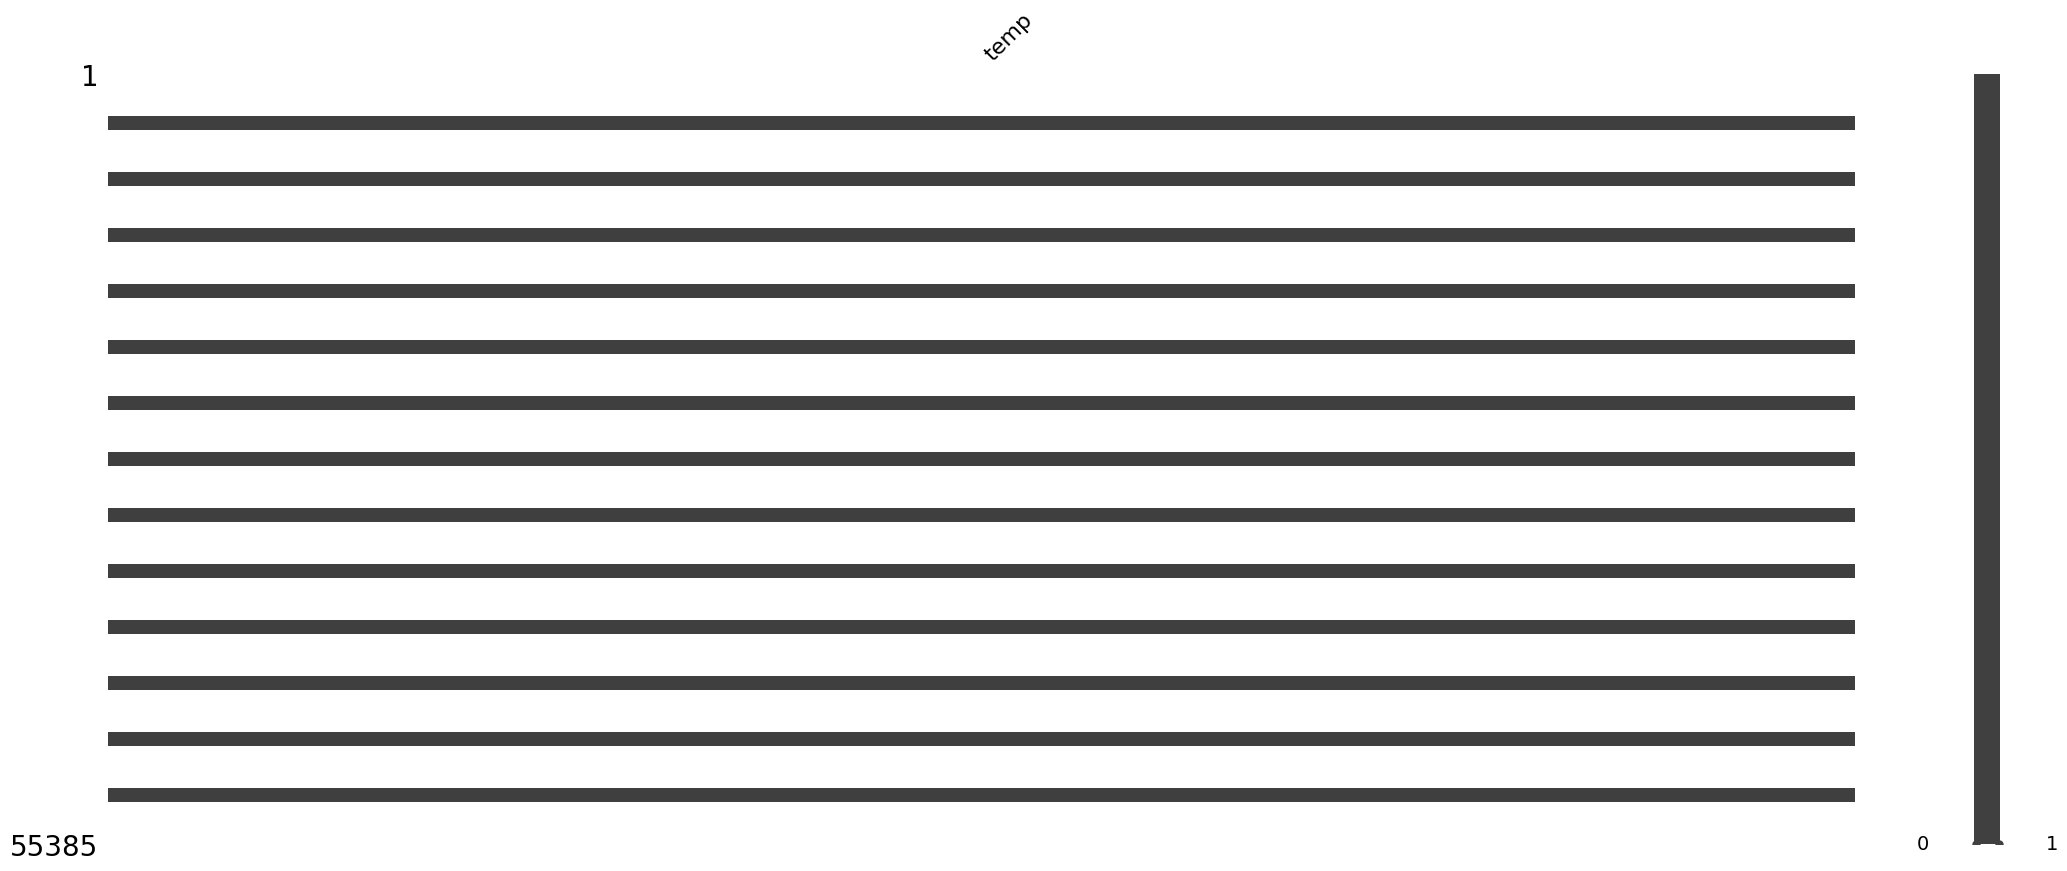

In [24]:
msno.matrix(lsc_temp);

Load Data: <br>
Now, there are no load periods that were not included in the original set.
We have double checked that we have no missings.
<br>
<br>
Temperature Data: <br>
There is missing data after getting the 15 minutes temperatuer data, that needs to filled

Fill the missings data in the tempertature by front filling, hence we set the same value for every 15 minutes in the hour

In [25]:
lsc_temp = lsc_temp.fillna(method="ffill")

In [26]:
lsc_temp.head()

,temp
time,
2021-10-01 01:00:00+00:00,26.1
2021-10-01 01:15:00+00:00,26.1
2021-10-01 01:30:00+00:00,26.1
2021-10-01 01:45:00+00:00,26.1
2021-10-01 02:00:00+00:00,25.0


Merge the dataset

In [27]:
df = lsc_load.merge(
    lsc_temp, left_index=True, right_index=True)
df.head()

,Load,temp
2022-03-01 00:15:00+00:00,85.38,17.8
2022-03-01 00:30:00+00:00,82.81,17.8
2022-03-01 00:45:00+00:00,81.88,17.8
2022-03-01 01:00:00+00:00,76.50,12.2
2022-03-01 01:15:00+00:00,76.75,12.2


#### Stationarity test

In [28]:
sts.adfuller(df.Load)

(-17.492417145580887,
 4.4296090376658705e-30,
 54,
 40837,
 {'1%': -3.4305101418100357,
  '5%': -2.861610779041176,
  '10%': -2.5668076734036696},
 335667.72204107686)

Load Data <br>
We reject the null hypothesis, hence there a stationarity in the data set (the previous 54 lags to the current lag have identical cov)

In [29]:
sts.adfuller(df.temp)

(-7.43720372624086,
 6.138682316774831e-11,
 52,
 40839,
 {'1%': -3.4305101339669504,
  '5%': -2.861610775574804,
  '10%': -2.5668076715586152},
 85175.75459719889)

Temp Data <br>
We reject the null hypothesis, hence there a stationarity in the data set (the previous 6 lags to the current lag have identical cov)

#### Seasonality Check
1. Additive

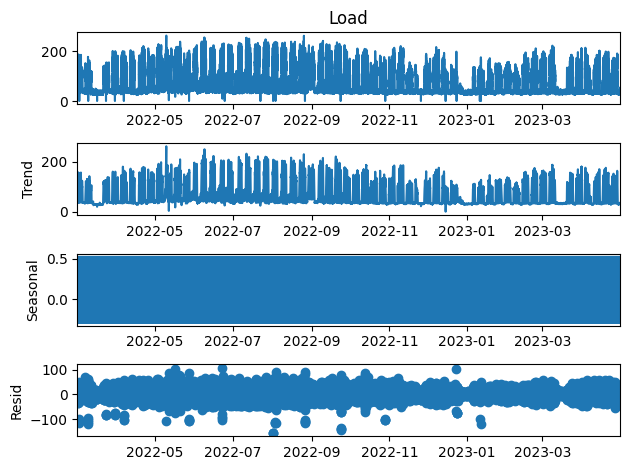

In [30]:
# test
df_additive_compose = sm.tsa.seasonal_decompose(df.Load,period=15, model="additive")
df_additive_compose.plot();

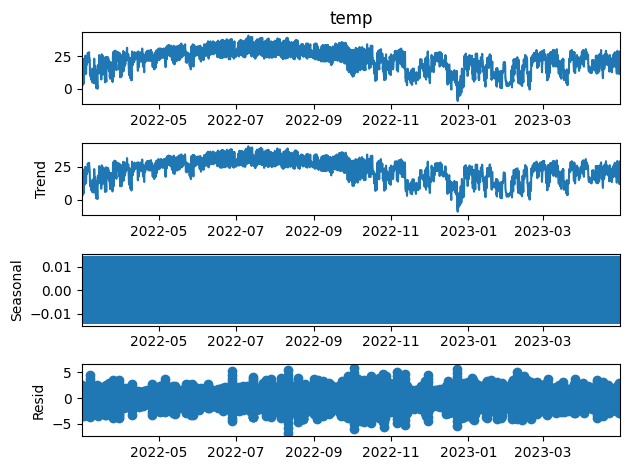

In [31]:
# test
df_additive_compose = sm.tsa.seasonal_decompose(df.temp,period=15, model="additive")
df_additive_compose.plot();

The seasonal is rectangle, hence values are oscillating up and down from 5 to -5 in the temperature, and from 0.01 to -0.01 in the load data
> No cyclical pattern,hence no seasonality

> The residual is big hence the differences between true and predicted values for any period is significant

#### ACF <br>


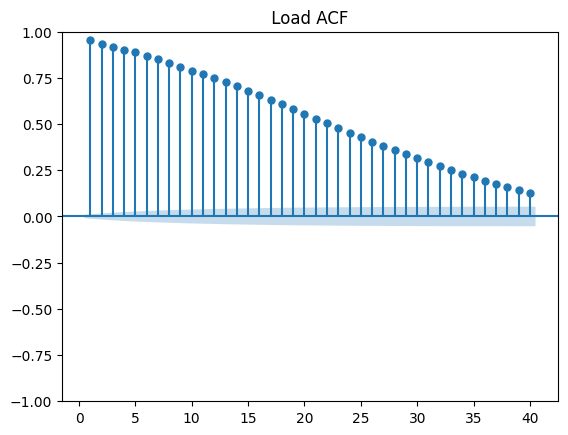

In [32]:
sgt.plot_acf(df.Load,lags=40,zero=False);
plt.title(" Load ACF ");

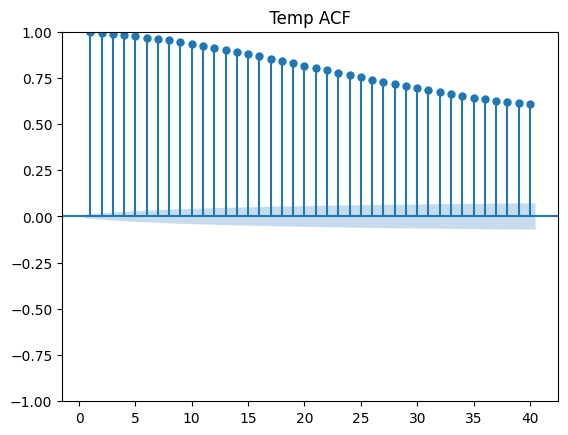

In [33]:
sgt.plot_acf(df.temp,lags=40,zero=False);
plt.title(" Temp ACF ");


- The significance graph (blue shade) is not expanding, hence significance difference of higher lags isn't significantly different from zero

- We set the lags to 40, the autocorrelation starting from the very previous lag to the 40th lag is decreasing especially in the load data , hence moving away from the current lag and taking these vales for prediction isn't useful.

PACF <br>
Direct to the current lag , used to detect the number of lags used in the modeling

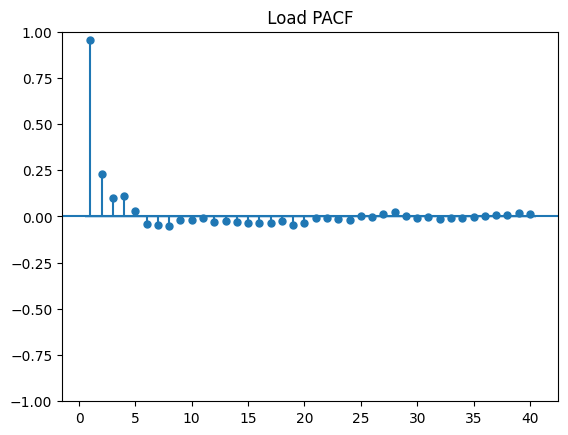

In [34]:
# using the order of least squares method
sgt.plot_pacf(df.Load,lags=40,zero=False,method=('ols'));
plt.title(" Load PACF ");

The are lags starting from 6 lags ago resulted in lower values

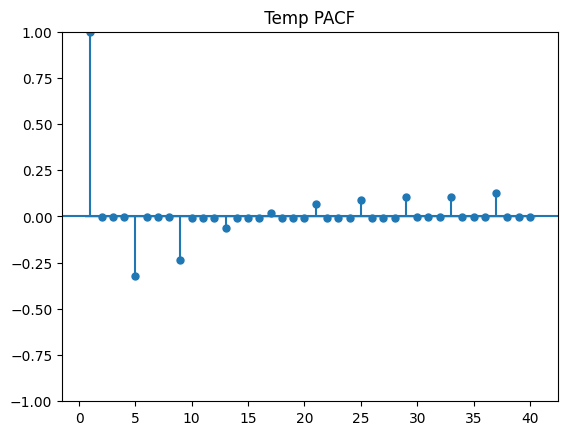

In [35]:
sgt.plot_pacf(df.temp,lags=40,zero=False,method=('ols'));
plt.title(" Temp PACF ");

The are lags in the 5th, 9th lags ago resulted in significantly lower values.


- Overall, the blue curve is vanished, and that resembles all coefficients attached to these lags should be zero( lags to be omitted)
- number of lags used is 25 for temperature and 7 for the load data

We need to construct a cutoff to split the data set at. <br>
We set the training set size of 80%



In [43]:
size=int(len(df)*0.8)
train=df[:size]
test=df[size:]

Text(0.5, 1.0, 'Load Vs Temp values')

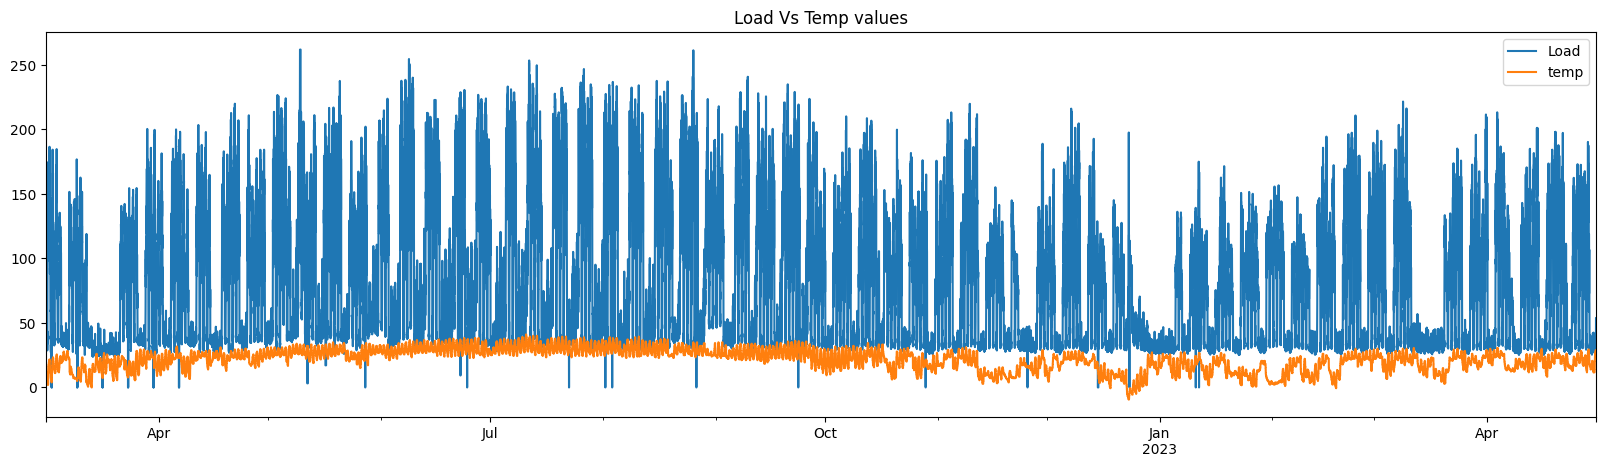

In [44]:
plt.figure(figsize=(20,5))
df['Load'].plot();
df['temp'].plot();
plt.legend()
plt.title( "Load Vs Temp values")

In [45]:
print("Training set ends at")
print(train.tail(1))
print("\nTesting set starts at")
print(test.head(1))


Training set ends at
                           Load  temp
2023-02-04 18:15:00+00:00  29.5  14.4

Testing set starts at
                            Load  temp
2023-02-04 18:30:00+00:00  32.25  14.4


The cutoff period is 2023-02-04 18:15

#### Modeling


##### 1. AR

In [88]:
'''
#constructing a simple AR(1) model without taking into consideration any residual values
ar_model= sm.tsa.arima.ARIMA(df.Load, order=(6,0,0));
ar_results=ar_model.fit();
'''

'\n#constructing a simple AR(1) model without taking into consideration any residual values\nar_model= sm.tsa.arima.ARIMA(df.Load, order=(6,0,0));\nar_results=ar_model.fit();\n'

In [89]:
'''
ar_results.summary()
'''

'\nar_results.summary()\n'

Having p-value =0 for both c and the ar.L1 resembles that they are significant different from zero. Having non zeros CI values , then the coefficients are significance.

##### LLR Test <br>
Showing if models are significanlty different or not


In [87]:
'''
# create lagged variables for load and temperature
p = 25 # order of the AR model
q = 7 # number of lags of temperature to include
Y = df.Load[p:]
X = np.column_stack([df.Load.shift(i)[p:] for i in range(1, p+1)] + [df.temp.shift(i)[p:] for i in range(1, q+1)])
X = sm.add_constant(X)

# fit the AR model using OLS regression
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

# forecast future values of the load given future values of temperature
forecast_periods = 12 # number of periods to forecast
forecast_X = np.column_stack([df.Load[-p+i:] for i in range(1, p+1)] + [df.temp[-q+i:] for i in range(1, q+1)])
forecast_X = sm.add_constant(forecast_X)
forecast_load = results.predict(forecast_X)
'''


'\n# create lagged variables for load and temperature\np = 25 # order of the AR model\nq = 7 # number of lags of temperature to include\nY = df.Load[p:]\nX = np.column_stack([df.Load.shift(i)[p:] for i in range(1, p+1)] + [df.temp.shift(i)[p:] for i in range(1, q+1)])\nX = sm.add_constant(X)\n\n# fit the AR model using OLS regression\nmodel = sm.OLS(Y, X)\nresults = model.fit()\nprint(results.summary())\n\n# forecast future values of the load given future values of temperature\nforecast_periods = 12 # number of periods to forecast\nforecast_X = np.column_stack([df.Load[-p+i:] for i in range(1, p+1)] + [df.temp[-q+i:] for i in range(1, q+1)])\nforecast_X = sm.add_constant(forecast_X)\nforecast_load = results.predict(forecast_X)\n'

In [ ]:
'''
plt.figure(figsize=(20,5))
plt.plot(df.Load)
plt.plot(np.arange(len(df.Load), len(df.Load)+forecast_periods), forecast_load)
plt.show()
'''

#### 3. Auto ARIMA without temprature



In [ ]:
#!pip install pmdarima


In [90]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Load'], trace=True,stepwise=True,
suppress_warnings=True)

In [79]:
from statsmodels.tsa.arima_model import ARIMA
model=sm.tsa.arima.ARIMA(train['Load'],order=(4,1,3))
model=model.fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Load   No. Observations:                32713
Model:                 ARIMA(4, 1, 3)   Log Likelihood             -135783.209
Date:                Fri, 16 Jun 2023   AIC                         271582.418
Time:                        09:05:23   BIC                         271649.582
Sample:                    03-01-2022   HQIC                        271603.880
                         - 02-04-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1409      1.545     -0.091      0.927      -3.170       2.888
ar.L2          0.0517      0.954      0.054      0.957      -1.818       1.921
ar.L3         -0.4182      0.615     -0.680      0.496      -1.623       0.787
ar.L4         -0.0930      0.188     -0.493      0.622      -0.462       0.276
ma.L1         -0.1437      1.545     -0.093      0.926      -3.173       2.885
ma.L2         -0.1609      1.393     -0.116      0.908      -2.891       2.569
ma.L3          0.3713      0.779      0.477      0.633      -1.155       1.897
sigma2       236.1327      0.690    342.242      0.000     234.780     237.485
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            318238.89
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model prediction on the training set

<Axes: >

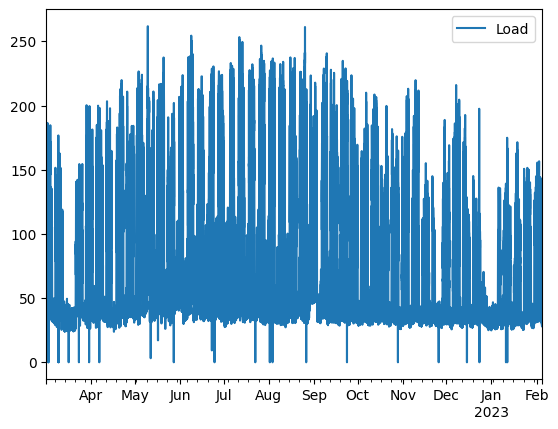

In [80]:
start=0
end=len(train)-1
pred=model.predict(start=start,end=end,typ='lags').rename('ARIMA Predictions')
train['Load'].plot(legend=True)

<Axes: >

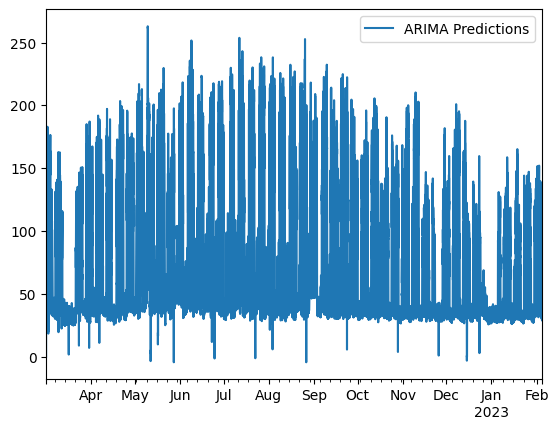

In [81]:
pred.plot(legend=True)

Model prediction on the testing set

<Axes: >

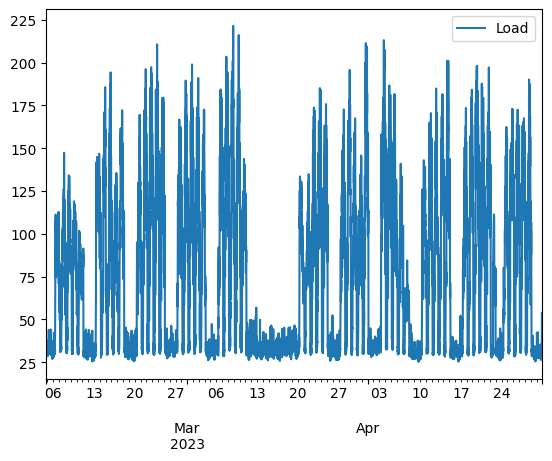

In [82]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
test['Load'].plot(legend=True)

<Axes: >

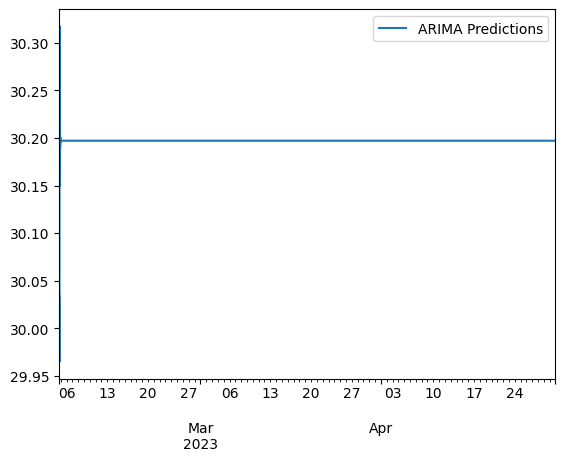

In [83]:
pred.plot(legend=True)


Model is overfitting

In [84]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Load'].mean()
rmse=sqrt(mean_squared_error(pred,test['Load']))
print(rmse)

63.40613710501589


#### 3. Auto ARIMA with temprature



In [ ]:
'''
model = pm.auto_arima(final_df['demand'],
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)
'''

#### LSTM

Splitting the dataset

In [ ]:
'''
from sia_ts_modelling.automate import pipeline
from sklearn.ensemble import RandomForestRegressor


(benchmarking_df, all_models, prediction_all_models,) = pipeline(
    input_df=df_load_temperature_holidays.dropna(),
    target_column="Historical_consumption",
    features_sets={
        "temperature_only": ["Historical_temperature_smoothed"],
        "temperature_day_month": [
            "Historical_temperature_smoothed",
            "day_of_week",
            "month",
        ],
        "temperature_day_month_hour": [
            "Historical_temperature_smoothed",
            "hour",
            "day_of_week",
            "month",
        ],
    },
    model_and_init_params=[
        {
            "name": "my_first_lasso",
            "model": "lasso",
            "features_sets": ["temperature_only", "temperature_day_month"],
            "model_by_moment": True,
            "period_moment": "hour",
        },
        {
            "name": "my_first_rf",
            "model": RandomForestRegressor,
            "features_sets": ["temperature_only"],
            "kwargs_build": {"n_estimators": 10},
            "model_by_moment": True,
            "period_moment": "hour",
        },
        {
            "name": "my_first_gam",
            "model": "gam",
            "features_sets": ["temperature_day_month"],
            "kwargs_build": {
                "s_terms": [
                    {
                        "feature": "Historical_temperature_smoothed",
                        "extra_kwargs": {"n_splines": 13},
                    },
                ],
                "f_terms": [
                    {
                        "feature": "day_of_week",
                    },
                    {
                        "feature": "month",
                    },
                ],
            },
            "model_by_moment": True,
            "period_moment": "hour",
        },
        {
            "name": "aggregate_model",
            "features_sets": ["temperature_day_month_hour"],
            "model": {"my_lasso": "lasso", "my_rf": RandomForestRegressor},
            "kwargs_build": {
                "weights": "trained",
                "my_rf": {"n_estimators": 10},
            },
            "model_by_moment": False,
            "period_moment": "hour",
        },
    ],
    train_test_split_method="split_proportion",
    test_size=0.25,
    metrics=["MAPE", "R2", "MSE"],
)
'''